In [1]:
from pathlib import Path
from itertools import combinations
import warnings

warnings.filterwarnings("ignore")
import sys
print(sys.executable)
print('\n'.join(sys.path))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, pairwise_distances, accuracy_score
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
from Annotatability import models
from Annotatability import metrics
import scvi
import logging
import squidpy as sq
import contextlib
import io
import random
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # Added imports
import scipy.sparse as sp
from sklearn.model_selection import train_test_split

logging.getLogger("scvi").setLevel(logging.WARNING)

SMALL_SIZE = 16
MEDIUM_SIZE = 20.5
BIGGER_SIZE = 24
#plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sc.set_figure_params(scanpy=True, fontsize=20.5)

# Define custom color palette
annotation_order = ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']
annotation_colors = ['green', 'orange', 'red']
palette = dict(zip(annotation_order, annotation_colors))

/Users/idansegal/Documents/Coding/Annotatability_transfer/new_clean_env/bin/python
/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload

/Users/idansegal/Documents/Coding/Annotatability_transfer/new_clean_env/lib/python3.9/site-packages


In [2]:
from pathlib import Path
from itertools import combinations
import warnings

warnings.filterwarnings("ignore")
import sys
print(sys.executable)
print('\n'.join(sys.path))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, pairwise_distances, accuracy_score
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
from Annotatability import models
from Annotatability import metrics
import scvi
import logging
import squidpy as sq
import contextlib
import io
import random
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # Added imports
import scipy.sparse as sp
from sklearn.model_selection import train_test_split

logging.getLogger("scvi").setLevel(logging.WARNING)

SMALL_SIZE = 16
MEDIUM_SIZE = 20.5
BIGGER_SIZE = 24
#plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sc.set_figure_params(scanpy=True, fontsize=20.5)

# Define custom color palette
annotation_order = ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']
annotation_colors = ['green', 'orange', 'red']
palette = dict(zip(annotation_order, annotation_colors))

/Users/idansegal/Documents/Coding/Annotatability_transfer/new_clean_env/bin/python
/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload

/Users/idansegal/Documents/Coding/Annotatability_transfer/new_clean_env/lib/python3.9/site-packages


In [3]:
from tqdm import tqdm
import contextlib
import io

# Initialize StringIO object to suppress outputs
f = io.StringIO()

def train_and_get_prob_list(adata, label_key, epoch_num, device=device, batch_size=128):
    print('Training the model...')
    with contextlib.redirect_stdout(f):
        prob_list = models.follow_training_dyn_neural_net(
            adata,
            label_key=label_key,
            iterNum=epoch_num,
            device=device,
            batch_size=batch_size
        )
    print('Training complete.')
    return prob_list

def calculate_confidence_and_variability(prob_list, n_obs, epoch_num):
    with contextlib.redirect_stdout(f):
        all_conf, all_var = models.probability_list_to_confidence_and_var(
            prob_list,
            n_obs=n_obs,
            epoch_num=epoch_num
        )
    return all_conf, all_var

def find_cutoffs(adata, label_key, device, probability, percentile, epoch_num):
    with contextlib.redirect_stdout(f):
        cutoff_conf, cutoff_var = models.find_cutoff_paramter(
            adata,
            label_key,
            device,
            probability=probability,
            percentile=percentile,
            epoch_num=epoch_num
        )
    return cutoff_conf, cutoff_var

def assign_annotations(adata, all_conf, all_var, cutoff_conf, cutoff_var, annotation_col='Annotation'):
    adata.obs["var"] = all_var.detach().numpy()
    adata.obs["conf"] = all_conf.detach().numpy()
    adata.obs['conf_binaries'] = pd.Categorical(
        (adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var)
    )

    annotation_list = []
    for i in tqdm(range(adata.n_obs), desc='Assigning annotations'):
        if adata.obs['conf_binaries'].iloc[i]:
            if (adata.obs['conf'].iloc[i] > 0.95) & (adata.obs['var'].iloc[i] < 0.15):
                annotation_list.append('Easy-to-learn')
            else:
                annotation_list.append('Ambiguous')
        else:
            annotation_list.append('Hard-to-learn')

    adata.obs[annotation_col] = annotation_list
    adata.obs['Confidence'] = adata.obs['conf']
    adata.obs['Variability'] = adata.obs['var']
    return adata

In [4]:
# Load and preprocess the data
adata_merfish = sq.datasets.merfish()
sc.pp.normalize_per_cell(adata_merfish, counts_per_cell_after=1e4)
sc.pp.log1p(adata_merfish)

# Map clusters to cell types
cell_type_mapping = {
    'OD Mature 2': 'OD Mature',
    'OD Immature 1': 'OD Immature',
    'Inhibitory': 'Inhibitory',
    'Excitatory': 'Excitatory',
    'Microglia': 'Microglia',
    'Astrocyte': 'Astrocyte',
    'Endothelial 2': 'Endothelial',
    'Endothelial 3': 'Endothelial',
    'Endothelial 1': 'Endothelial',
    'OD Mature 1': 'OD Mature',
    'OD Mature 4': 'OD Mature',
    'Pericytes': 'Pericytes',
    'OD Mature 3': 'OD Mature',
    'Ependymal': 'Ependymal',
    'OD Immature 2': 'OD Immature'
}
adata_merfish.obs['CellType'] = adata_merfish.obs['Cell_class'].map(cell_type_mapping).fillna(adata_merfish.obs['Cell_class'])

In [5]:
prob_list_merfish_new = train_and_get_prob_list(adata_merfish, label_key='CellType', epoch_num=150, device=device, batch_size=64)

# train and get conf and var of merfish
all_conf_merfish, all_var_merfish = calculate_confidence_and_variability(prob_list_merfish_new, n_obs=adata_merfish.n_obs, epoch_num=150)

# find cutoffs of merdish 
conf_cutoff, var_cutoff = find_cutoffs(adata_merfish, 'CellType', device, probability=0.1, percentile=90, epoch_num=150)

# Assign annotations
adata_merfish = assign_annotations(adata_merfish, all_conf_merfish, all_var_merfish, conf_cutoff, var_cutoff, annotation_col='Annotation')

# count the number of cells in each group
group_counts = adata_merfish.obs['Annotation'].value_counts()

print(group_counts)

Training the model...
Training complete.


Assigning annotations: 100%|██████████| 73642/73642 [00:01<00:00, 45526.21it/s]

Annotation
Ambiguous        38606
Easy-to-learn    31302
Hard-to-learn     3734
Name: count, dtype: int64


In [6]:
# Assuming 'group_counts' is a pandas Series with annotations as indices
group_counts = adata_merfish.obs['Annotation'].value_counts()

# Assign counts to E, A, H
E = group_counts.get('Easy-to-learn', 0)
A = group_counts.get('Ambiguous', 0)
H = group_counts.get('Hard-to-learn', 0)

# Get the indices of each group
easy_indices = adata_merfish.obs.index[adata_merfish.obs['Annotation'] == 'Easy-to-learn'].tolist()
ambiguous_indices = adata_merfish.obs.index[adata_merfish.obs['Annotation'] == 'Ambiguous'].tolist()
hard_indices = adata_merfish.obs.index[adata_merfish.obs['Annotation'] == 'Hard-to-learn'].tolist()

# Verify the counts match E, A, H
print(f"Number of Easy-to-learn samples: {len(easy_indices)}")
print(f"Number of Ambiguous samples: {len(ambiguous_indices)}")
print(f"Number of Hard-to-learn samples: {len(hard_indices)}")

Number of Easy-to-learn samples: 31302
Number of Ambiguous samples: 38606
Number of Hard-to-learn samples: 3734


In [ ]:
import random
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import scipy.sparse as sp
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from tqdm import tqdm

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Fit LabelEncoder on the entire dataset labels
global_label_encoder = LabelEncoder()
global_label_encoder.fit(adata_merfish.obs['CellType'])
num_classes = len(global_label_encoder.classes_)

# Define the neural network class and helper functions
class BaseNet(nn.Module):
    def __init__(self, layer_sizes):
        super(BaseNet, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return torch.log_softmax(x, dim=1)

class Net(BaseNet):
    def __init__(self, input_size, output_size):
        layer_sizes = [input_size, int(input_size / 2), int(input_size / 4), output_size]
        super(Net, self).__init__(layer_sizes)

def one_hot_encode(labels, label_encoder):
    values = np.array(labels)
    integer_encoded = label_encoder.transform(values)
    onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

def is_scipy_cs_sparse(matrix):
    return sp.issparse(matrix) and matrix.getformat() == 'csr'

# Function to train and evaluate the model on a test set
def train_and_evaluate_model(adata_train, adata_test, label_key, label_encoder, epoch_num, device=device, batch_size=128):
    # Encode labels using the global label encoder
    one_hot_label_train = one_hot_encode(adata_train.obs[label_key], label_encoder=label_encoder)
    one_hot_label_test = one_hot_encode(adata_test.obs[label_key], label_encoder=label_encoder)

    net = Net(adata_train.X.shape[1], output_size=num_classes)
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    # Prepare training data
    if is_scipy_cs_sparse(adata_train.X):
        x_train = adata_train.X.toarray()
    else:
        x_train = np.array(adata_train.X)
    tensor_x_train = torch.Tensor(x_train).to(device)
    tensor_y_train = torch.LongTensor(np.argmax(one_hot_label_train, axis=1)).to(device)
    train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Prepare test data
    if is_scipy_cs_sparse(adata_test.X):
        x_test = adata_test.X.toarray()
    else:
        x_test = np.array(adata_test.X)
    tensor_x_test = torch.Tensor(x_test).to(device)
    tensor_y_test = torch.LongTensor(np.argmax(one_hot_label_test, axis=1)).to(device)

    # Train the network
    net.train()
    for epoch in range(epoch_num):
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on test set
    net.eval()
    with torch.no_grad():
        outputs = net(tensor_x_test)
        test_loss = criterion(outputs, tensor_y_test).item()

    return test_loss

# Load existing results from CSV or create an empty DataFrame
csv_file = 'best_compositions.csv'
try:
    results_df = pd.read_csv(csv_file)
except FileNotFoundError:
    results_df = pd.DataFrame(columns=['Train_Size', 'Easy', 'Ambiguous', 'Hard', 'Test_Loss'])

# Define the number of repeats per train size
repeats_per_size = 12  # Set this to your desired number of repeats

# Convert the 'Train_Size' column to a dictionary with counts for faster lookup
existing_counts = results_df['Train_Size'].value_counts().to_dict()

# Now, for dataset sizes (train sizes)
train_sizes = [500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000]
best_compositions = {}

for T in train_sizes:
    current_runs = existing_counts.get(T, 0)
    runs_needed = repeats_per_size - current_runs

    if runs_needed <= 0:
        # Use existing entries
        existing_rows = results_df[results_df['Train_Size'] == T]
        for idx, row in existing_rows.iterrows():
            easy = row['Easy']
            ambiguous = row['Ambiguous']
            hard = row['Hard']
            test_loss = row['Test_Loss']
            print(
                f"Using cached result for Train_Size={T}: Easy={easy}, Ambiguous={ambiguous}, Hard={hard}, Test Loss={test_loss}"
            )
            # You can choose how to store multiple runs. Here, we store all runs in a list.
            if T not in best_compositions:
                best_compositions[T] = []
            best_compositions[T].append({'composition': (easy, ambiguous, hard), 'Test_Loss': test_loss})
        continue  # Skip computation for this T as all repeats are already done

    else:
        print(f"\nProcessing train dataset size: {T} (Run {current_runs + 1} to {repeats_per_size})")

        for run in range(current_runs + 1, repeats_per_size + 1):
            print(f"\n--- Run {run} for Train_Size={T} ---")

            # Calculate test size (25% of train size)
            test_size = int(0.25 * T)
            total_size = T + test_size
            print(f"Total dataset size (Train + Test): {total_size} (Train: {T}, Test: {test_size})")

            # Define step size as a function of T
            step_size = max(1, T // 100)

            # Generate compositions summing up to T (train size)
            compositions = []
            for e in range(0, min(T, E) + 1, step_size):
                for a in range(0, min(T - e, A) + 1, step_size):
                    h = T - e - a
                    if h >= 0 and h <= H:
                        compositions.append((e, a, h))
            if not compositions:
                print(f"No valid compositions for Train Size={T}")
                # Save an entry indicating no valid compositions
                new_row = {'Train_Size': T, 'Easy': None, 'Ambiguous': None, 'Hard': None, 'Test_Loss': None}
                # Replace append with pd.concat
                new_row_df = pd.DataFrame([new_row])
                results_df = pd.concat([results_df, new_row_df], ignore_index=True)
                results_df.to_csv(csv_file, index=False)
                continue

            print(f"Total compositions for Train Size={T}: {len(compositions)}")

            min_loss = float('inf')
            best_comp = None

            # For each composition, train and get test loss
            for comp in tqdm(compositions, desc=f"Testing compositions for Train Size={T} - Run {run}"):
                e, a, h = comp
                # Ensure not exceeding group counts
                if e > E or a > A or h > H:
                    continue  # Invalid composition

                # Ensure we have enough samples in each group
                if len(easy_indices) < e or len(ambiguous_indices) < a or len(hard_indices) < h:
                    continue  # Skip if not enough samples

                # Randomly sample e, a, h samples from each group for training
                train_easy_indices = random.sample(easy_indices, e) if e > 0 else []
                train_ambiguous_indices = random.sample(ambiguous_indices, a) if a > 0 else []
                train_hard_indices = random.sample(hard_indices, h) if h > 0 else []
                train_indices = train_easy_indices + train_ambiguous_indices + train_hard_indices

                # Ensure total train samples equal T
                if len(train_indices) != T:
                    continue  # Skip if train size mismatch

                # All indices excluding the ones in train_indices
                remaining_indices = list(set(adata_merfish.obs.index) - set(train_indices))

                # Ensure we have enough remaining samples for test set
                if len(remaining_indices) < test_size:
                    continue  # Skip if not enough samples

                # Randomly sample test_size samples from remaining_indices
                test_indices = random.sample(remaining_indices, test_size)

                # Create training and testing datasets
                adata_train = adata_merfish[train_indices].copy()
                adata_test = adata_merfish[test_indices].copy()

                # Train and get test loss
                test_loss = train_and_evaluate_model(
                    adata_train, adata_test, label_key='CellType', label_encoder=global_label_encoder,
                    epoch_num=30, device=device, batch_size=64
                )
                # Update minimum loss and best composition
                if test_loss < min_loss:
                    min_loss = test_loss
                    best_comp = comp

            if best_comp is not None:
                easy, ambiguous, hard = best_comp
                print(
                    f"Best composition for Train_Size={T} (Run {run}): Easy={easy}, Ambiguous={ambiguous}, Hard={hard}, Test Loss={min_loss}"
                )
                # Append to best_compositions
                if T not in best_compositions:
                    best_compositions[T] = []
                best_compositions[T].append({'composition': best_comp, 'Test_Loss': min_loss})
                # Save the result to the DataFrame and CSV
                new_row = {
                    'Train_Size': T,
                    'Easy': easy,
                    'Ambiguous': ambiguous,
                    'Hard': hard,
                    'Test_Loss': min_loss
                }
                # Replace append with pd.concat
                new_row_df = pd.DataFrame([new_row])
                results_df = pd.concat([results_df, new_row_df], ignore_index=True)
                results_df.to_csv(csv_file, index=False)
            else:
                print(f"No valid compositions found for Train_Size={T} (Run {run})")
                # Save an entry indicating no valid compositions
                new_row = {'Train_Size': T, 'Easy': None, 'Ambiguous': None, 'Hard': None, 'Test_Loss': None}
                # Replace append with pd.concat
                new_row_df = pd.DataFrame([new_row])
                results_df = pd.concat([results_df, new_row_df], ignore_index=True)
                results_df.to_csv(csv_file, index=False)

Using cached result for Train_Size=500: Easy=450.0, Ambiguous=15.0, Hard=35.0, Test Loss=0.6885666251182556
Using cached result for Train_Size=500: Easy=370.0, Ambiguous=105.0, Hard=25.0, Test Loss=0.7026511430740356
Using cached result for Train_Size=500: Easy=265.0, Ambiguous=210.0, Hard=25.0, Test Loss=0.6898499131202698
Using cached result for Train_Size=500: Easy=400.0, Ambiguous=75.0, Hard=25.0, Test Loss=0.6923775672912598
Using cached result for Train_Size=500: Easy=460.0, Ambiguous=40.0, Hard=0.0, Test Loss=0.7038680911064148
Using cached result for Train_Size=500: Easy=480.0, Ambiguous=0.0, Hard=20.0, Test Loss=0.6936104893684387
Using cached result for Train_Size=500: Easy=285.0, Ambiguous=190.0, Hard=25.0, Test Loss=0.6578734517097473
Using cached result for Train_Size=500: Easy=465.0, Ambiguous=25.0, Hard=10.0, Test Loss=0.6729109287261963
Using cached result for Train_Size=500: Easy=420.0, Ambiguous=75.0, Hard=5.0, Test Loss=0.6865877509117126
Using cached result for Trai

# Visualizations

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the compositions from the CSV file
csv_file = 'best_compositions.csv'
try:
    results_df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"CSV file '{csv_file}' not found.")
    results_df = pd.DataFrame(columns=['Train_Size', 'Easy', 'Ambiguous', 'Hard', 'Test_Loss'])

# Filter out rows with missing compositions
results_df = results_df.dropna(subset=['Easy', 'Ambiguous', 'Hard'])

# Convert counts to floats and Train_Size to int
results_df['Easy'] = results_df['Easy'].astype(float)
results_df['Ambiguous'] = results_df['Ambiguous'].astype(float)
results_df['Hard'] = results_df['Hard'].astype(float)
results_df['Train_Size'] = results_df['Train_Size'].astype(int)

# Check if all train sizes have the same number of runs
counts_per_size = results_df['Train_Size'].value_counts()
if counts_per_size.nunique() != 1:
    print("Warning: Not all train sizes have the same number of rows in the CSV for each train size.")

# Calculate total and proportions for each row
results_df['Total'] = results_df['Easy'] + results_df['Ambiguous'] + results_df['Hard']
results_df['Proportion_Easy'] = results_df['Easy'] / results_df['Total']
results_df['Proportion_Ambiguous'] = results_df['Ambiguous'] / results_df['Total']
results_df['Proportion_Hard'] = results_df['Hard'] / results_df['Total']

# Group by Train_Size and calculate mean and standard deviation of proportions
grouped = results_df.groupby('Train_Size').agg({
    'Proportion_Easy': ['mean', 'std'],
    'Proportion_Ambiguous': ['mean', 'std'],
    'Proportion_Hard': ['mean', 'std']
}).reset_index()

# Flatten MultiIndex columns
grouped.columns = ['Train_Size',
                   'Proportion_Easy_mean', 'Proportion_Easy_std',
                   'Proportion_Ambiguous_mean', 'Proportion_Ambiguous_std',
                   'Proportion_Hard_mean', 'Proportion_Hard_std']

# Ensure that the mean proportions sum to 1 (optional assertion)
assert np.allclose(grouped[['Proportion_Easy_mean', 'Proportion_Ambiguous_mean', 'Proportion_Hard_mean']].sum(axis=1), 1), "Mean proportions do not sum to 1."

# Prepare data for plotting
train_sizes = grouped['Train_Size'].values
proportion_e_mean = grouped['Proportion_Easy_mean'].values
proportion_a_mean = grouped['Proportion_Ambiguous_mean'].values
proportion_h_mean = grouped['Proportion_Hard_mean'].values
proportion_e_std = grouped['Proportion_Easy_std'].values
proportion_a_std = grouped['Proportion_Ambiguous_std'].values
proportion_h_std = grouped['Proportion_Hard_std'].values

# Verify that all arrays have the same length
array_lengths = [len(train_sizes), len(proportion_e_mean), len(proportion_a_mean), len(proportion_h_mean),
                len(proportion_e_std), len(proportion_a_std), len(proportion_h_std)]
if len(set(array_lengths)) != 1:
    raise ValueError(f"Array length mismatch: {array_lengths}")

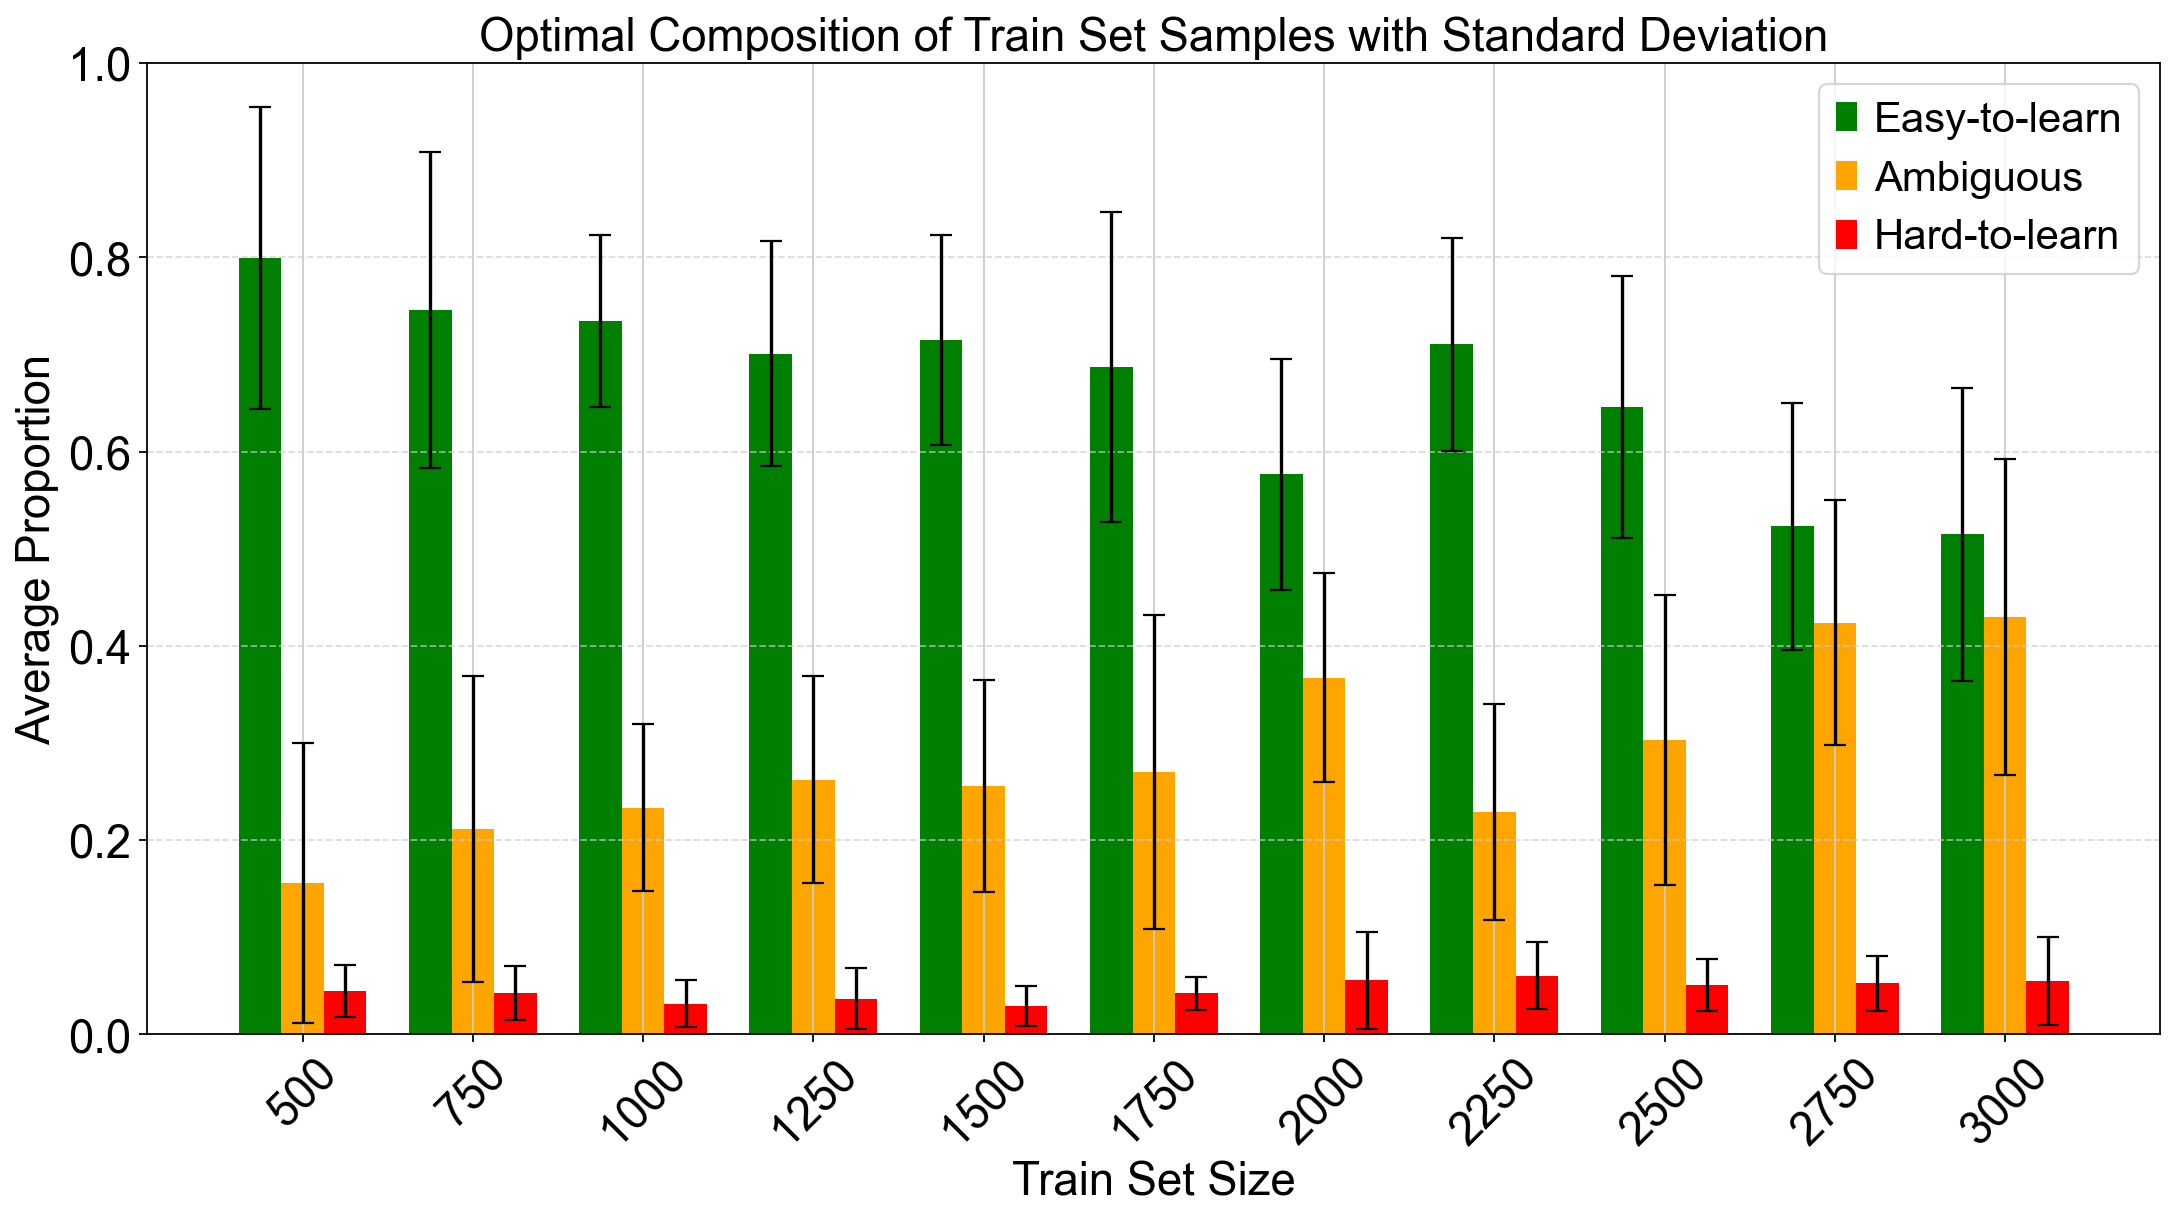

In [9]:
# Plotting grouped bar chart with error bars (variance) without percentage labels

import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
# (Assuming 'grouped' DataFrame is already prepared in the preprocessing cell)
train_sizes = grouped['Train_Size'].values
proportion_e_mean = grouped['Proportion_Easy_mean'].values
proportion_a_mean = grouped['Proportion_Ambiguous_mean'].values
proportion_h_mean = grouped['Proportion_Hard_mean'].values
proportion_e_std = grouped['Proportion_Easy_std'].values
proportion_a_std = grouped['Proportion_Ambiguous_std'].values
proportion_h_std = grouped['Proportion_Hard_std'].values

# Set up the plot for Grouped Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.25
index = np.arange(len(train_sizes))

# Plot each category as separate bars with error bars
bars_easy = ax.bar(index - bar_width, proportion_e_mean, bar_width, yerr=proportion_e_std,
                  label='Easy-to-learn', color='green', capsize=5)
bars_ambiguous = ax.bar(index, proportion_a_mean, bar_width, yerr=proportion_a_std,
                        label='Ambiguous', color='orange', capsize=5)
bars_hard = ax.bar(index + bar_width, proportion_h_mean, bar_width, yerr=proportion_h_std,
                  label='Hard-to-learn', color='red', capsize=5)

# Customize the axes
ax.set_xticks(index)
ax.set_xticklabels([str(size) for size in train_sizes], rotation=45)
ax.set_ylabel('Average Proportion')
ax.set_xlabel('Train Set Size')
ax.set_title('Optimal Composition of Train Set Samples with Standard Deviation')
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

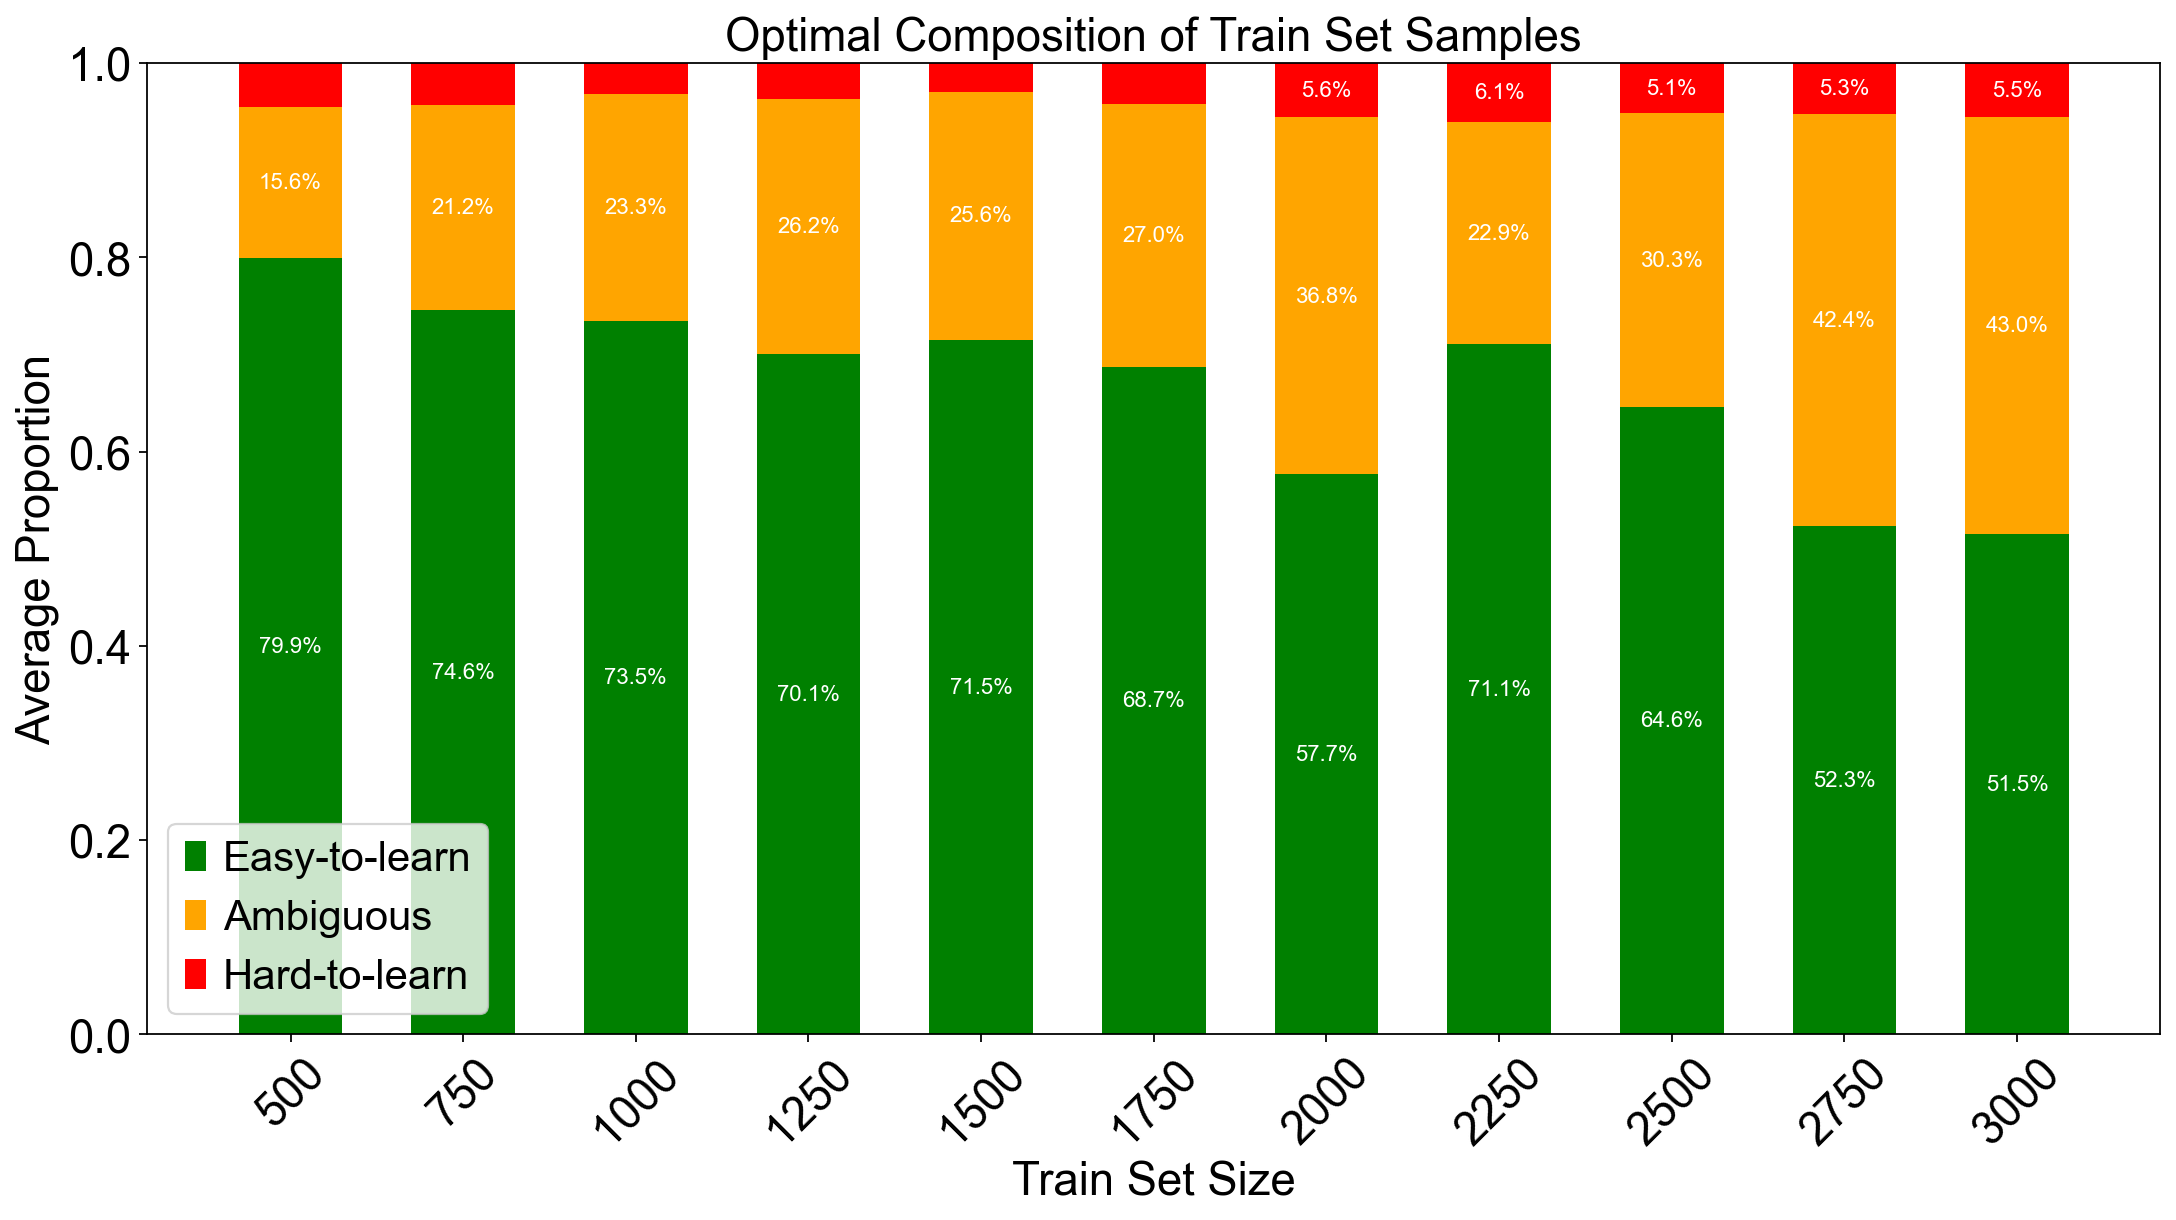

In [10]:
# Plotting stacked bar chart without error bars but with percentage labels

import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
# (Assuming 'grouped' DataFrame is already prepared in the preprocessing cell)
# train_sizes, proportion_e_mean, proportion_a_mean, proportion_h_mean are already defined

# Set up the plot for Stacked Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.6
index = np.arange(len(train_sizes))

# Plot Easy-to-learn segment
bars_easy = ax.bar(index, proportion_e_mean, bar_width, label='Easy-to-learn', color='green')

# Plot Ambiguous segment on top of Easy-to-learn
bars_ambiguous = ax.bar(index, proportion_a_mean, bar_width, bottom=proportion_e_mean,
                        label='Ambiguous', color='orange')

# Plot Hard-to-learn segment on top of Ambiguous
bars_hard = ax.bar(index, proportion_h_mean, bar_width, bottom=proportion_e_mean + proportion_a_mean,
                  label='Hard-to-learn', color='red')

# Add percentage labels
for i in range(len(train_sizes)):
    # Easy-to-learn
    if proportion_e_mean[i] > 0.05:
        ax.text(index[i], proportion_e_mean[i]/2,
                f"{proportion_e_mean[i]*100:.1f}%", ha='center', va='center',
                color='white', fontsize=10)
    # Ambiguous
    if proportion_a_mean[i] > 0.05:
        ax.text(index[i], proportion_e_mean[i] + proportion_a_mean[i]/2,
                f"{proportion_a_mean[i]*100:.1f}%", ha='center', va='center',
                color='white', fontsize=10)
    # Hard-to-learn
    if proportion_h_mean[i] > 0.05:
        ax.text(index[i], proportion_e_mean[i] + proportion_a_mean[i] + proportion_h_mean[i]/2,
                f"{proportion_h_mean[i]*100:.1f}%", ha='center', va='center',
                color='white', fontsize=10)

# Customize the axes
ax.set_xticks(index)
ax.set_xticklabels([str(size) for size in train_sizes], rotation=45)
ax.set_ylabel('Average Proportion')
ax.set_xlabel('Train Set Size')
ax.set_title('Optimal Composition of Train Set Samples')
ax.legend(loc='lower left')
ax.set_ylim(0, 1)
ax.grid(False)

plt.tight_layout()
plt.show()